# Introduction 

## Problems listed below

Why would you ever use a single processor? 

In [1]:
addprocs(7);

In [2]:
@everywhere using Images;

In [ ]:
@everywhere using Graphs;

In [3]:
using Gadfly, Base.Test;

    +(AbstractArray{T,N},DataArray{T,N}) at /home/elpinguino/.julia/DataArrays/src/operators.jl:326
is ambiguous with: 
    +(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/elpinguino/.julia/Images/src/algorithms.jl:18.
To fix, define 
    +(AbstractImageDirect{T,N},DataArray{T,N})
before the new definition.
    +(AbstractArray{T,N},AbstractDataArray{T,N}) at /home/elpinguino/.julia/DataArrays/src/operators.jl:349
is ambiguous with: 
    +(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/elpinguino/.julia/Images/src/algorithms.jl:18.
To fix, define 
    +(AbstractImageDirect{T,N},AbstractDataArray{T,N})
before the new definition.
    -(AbstractArray{T,N},DataArray{T,N}) at /home/elpinguino/.julia/DataArrays/src/operators.jl:326
is ambiguous with: 
    -(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/elpinguino/.julia/Images/src/algorithms.jl:35.
To fix, define 
    -(AbstractImageDirect{T,N},DataArray{T,N})
before the new definition.
    -(AbstractDataArray{T,N},Abst

We test a few methods such that our code doesn't run like "research code". The idea is to build a random, binary matrix representing forest presence or absence. First We try an approach using Images.jl library to classify groups of pixels in a matrix.

In [4]:
@everywhere function collect_groups(labels)
     groups = [Int[] for i = 1:maximum(labels)]
     for (i,l) in enumerate(labels)
         if l != 0
             push!(groups[l], i)
         end
     end
     groups
end

In [5]:
function alternateVersion(mat::BitArray{2})
    labels = label_components(mat)
    largest = 0
    for i in collect_groups(labels)
        if length(i) > largest largest = length(i) end
    end 
    largest
end

alternateVersion (generic function with 1 method)

The second approach uses Graphs.jl. We convert our binary matrix into a graph and then employ graph techniques to find connected pixels.

In [55]:
# Row major indexing
# row i col j total columns n
@everywhere function indexToNode(i, j, n)
 (i - 1)n + j
end

@test indexToNode(1,1,4) == 1
@test indexToNode(2,1,4) == 5
@test indexToNode(3,3,4) == 11

In [142]:
# Transforms a row major vector index into a matrix index
# α index n total columns
# Not happy with this solution but have lost interest in the problem.
@everywhere function nodeToIndex(α::Int, n::Int)
    a = divrem(α, n)
    i = a[1]
    if i == 0 
        i = 1
    else
        i = i + 1
    end
    j = a[2]
    if j == 0 
        j = n
        i = i - 1
    end
    (i,j)
end

@test nodeToIndex(1, 4) == (1,1)
@test nodeToIndex(16, 4) == (4,4)
@test nodeToIndex(5, 4) == (2,1)
@test nodeToIndex(9, 4) == (3,1)
@test nodeToIndex(13, 4) == (4,1)
@test nodeToIndex(4, 4) == (1,4)

# Fully test a 3x3
@test nodeToIndex(1,3) == (1,1)
@test nodeToIndex(2,3) == (1,2)
@test nodeToIndex(3,3) == (1,3)
@test nodeToIndex(4,3) == (2,1)
@test nodeToIndex(5,3) == (2,2)
@test nodeToIndex(6,3) == (2,3)
@test nodeToIndex(7,3) == (3,1)
@test nodeToIndex(8,3) == (3,2)
@test nodeToIndex(9,3) == (3,3)

In [6]:
@everywhere function matToGraph(A)
     g = simple_graph(length(A), is_directed = false)
     m = size(A,1)
     n = size(A,2)
     for i = 1:m, j=1:n
         if A[i,j]
             node = indexToNode(i,j,n)
             # Check above
             if i - 1 > 0 && A[i - 1, j]
                 add_edge!(g, node, indexToNode(i - 1, j, n))
             end
             # Check below
             if i + 1 <= m && A[i + 1, j]
                 add_edge!(g, node, indexToNode(i + 1, j, n))
             end
             # Check left
             if j - 1 > 0 && A[i, j - 1]
                 add_edge!(g, node, indexToNode(i, j - 1, n))
             end
             # Check right
             if j + 1 <= n && A[i, j + 1]
                 add_edge!(g, node, indexToNode(i, j + 1, n))
             end
         end
     end
     g
end

In [6]:
@everywhere function getLargestComponent(g::GenericGraph)
     largest = 0
     for i in connected_components(g)
         l = length(i)
         if l > largest largest = l end
     end
    largest
end

exception on exception on 2: 1: exception on exception on 3: 4: exception on 5: ERROR: GenericGraph not defined
 in eval at /build/buildd/julia-0.3.6-depsfix9/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous at multi.jl:848
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6
ERROR: GenericGraph not defined
 in eval at /build/buildd/julia-0.3.6-depsfix9/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous at multi.jl:848
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6
ERROR: GenericGraph not defined
 in eval at /build/buildd/julia-0.3.6-depsfix9/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in run_work_thunk at multi.jl:621
 in run_work_thunk at multi.jl:630
 in anonymous at task.jl:6
exception on 6: exception on exception on 7: 8: ERROR: GenericGraph not defined
 in eval at /build/buildd/julia-0.3.6-depsfix9/base/sysimg.jl:7
 in anonymous at multi.jl:1310
 in anonymous

In [8]:
function graphVersion(mat)
     getLargestComponent(matToGraph(mat))
end

graphVersion (generic function with 1 method)

In [9]:
mat = rand(100,100) .<= .5;

Make sure to run a few times such that the code is optimized for speed tests.

In [14]:
@elapsed alternateVersion(mat)

0.000504207

In [17]:
@elapsed graphVersion(mat)

0.084328085

For this problem we'll use the Images.jl version.

In [7]:
@everywhere function getLargestComponent(mat::BitArray{2})
     labels = label_components(mat)
     largest = 0
     for i in collect_groups(labels)
         if length(i) > largest largest = length(i) end
     end 
     largest
end

In [8]:
# Create an n X n model and find the largest average component over r trials 
# given probability increment p
function getAverageConnectedComponents(n::Int, r::Int, p::Float64)
     probs = [p:p:1]
     avgsize = zeros(Float64, length(probs))
     for i in 1:length(probs)
         totalsize = @parallel (+) for j in 1:r
             A = rand(n,n) .<= probs[i]
             getLargestComponent(A)
         end
         avgsize[i] = totalsize / r
     end
     avgsize
end

getAverageConnectedComponents (generic function with 1 method)

Let's see what kind of growth we're looking at

In [613]:
p = 10^-2.0
n = [10, 20, 40, 80, 160]
m = length(n)
time = zeros(m)
for i in 1:m
    time[i] = @elapsed getAverageConnectedComponents(n[i], 100, p)
end

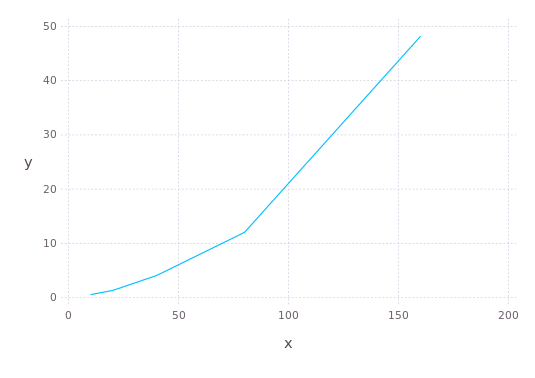

In [614]:
plot(x=n, y=time, Geom.line, Guide.xlabel("N"), Guide.ylabel("Time"))

Growth is non-linear but not terrible. We might wait a couple of minutes for problem 3 to compute.

# Problem 3 

In [10]:
p = 10^-2.0
L = [20, 50, 100, 200, 500, 1000]
forestSize = Array(Array{Float64,1}, length(L))
for i in 1:length(L)
     forestSize[i] = getAverageConnectedComponents(L[i], 100, p) / L[i]^2
end

In [11]:
using DataFrames

In [13]:
forests = DataFrame(Probability = [p:p:1], 
L20 = forestSize[1], 
L50 = forestSize[2], 
L100 = forestSize[3],
L200 = forestSize[4],
L500 = forestSize[5],
L1000 = forestSize[6]);

# a) 

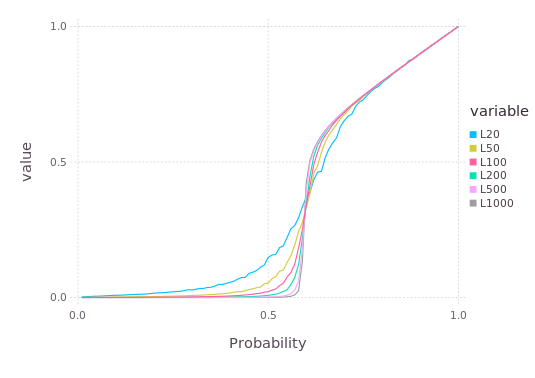

In [14]:
plot(melt(forests, :Probability), x = "Probability", y = "value", color = "variable", Geom.line)

# b)

We find that as $N \to \infty$ the curve defined by $S_{avg}$ as a function of probability becomes more severe; that is to say the critical probability approaches some limiting value. In this experiment our best estimate of the limiting value is $0.58$. 

# Problem 4 

In [48]:
function getDistribution(p, n)
     A = rand(n,n) .<= p
     groups = collect_groups(label_components(A))
     sizes = Array(Int, length(groups))
     for i in 1:length(groups)
         sizes[i] = length(groups[i])
     end
     sizes
end

getDistribution (generic function with 1 method)

In [49]:
p = 0.58;

# a) 

In [50]:
pcrit = getDistribution(p, 5000);

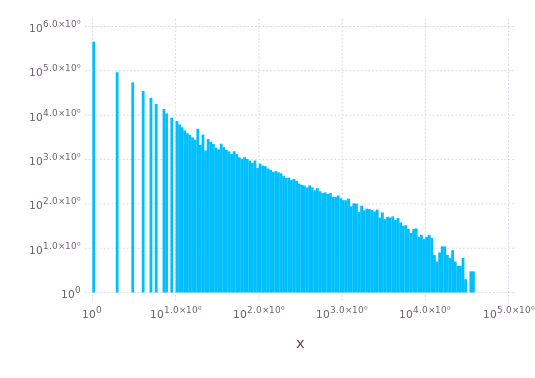

In [51]:
plot(x = pcrit, Geom.histogram, Scale.x_log10(format=:scientific, maxvalue = 10^5), 
Scale.y_log10(format=:scientific, maxvalue = 10^5))

The distribution of forest sizes is a power law with an exponent of about $1$.

# b) 

In [52]:
psmall = getDistribution(p / 2, 5000);

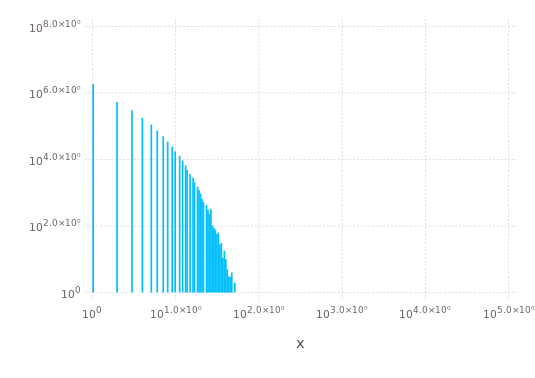

In [53]:
plot(x = psmall, Geom.histogram, Scale.x_log10(format=:scientific, maxvalue = 10^5), 
Scale.y_log10(format=:scientific, maxvalue = 10^5))

In [54]:
plarge = getDistribution(p + (1-p) / 2, 5000);

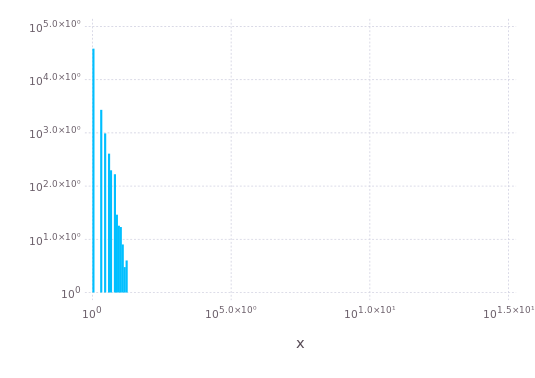

In [55]:
plot(x = plarge, Geom.histogram, Scale.x_log10(format=:scientific, maxvalue = 10^5), 
Scale.y_log10(format=:scientific, maxvalue = 10^5))

Note that the double logarithmic plot illustrates that neither distribution fit a power law well. These are not power laws.

# Problem 5 

In [579]:
@everywhere using StatsBase

Setup our tree number of design array.

In [34]:
n = 100
D = [1,2,convert(Int, floor(sqrt(n))),n];

Solving for the normalization constant is a bit of a pain. Let's just use an estimate with an error equal to machine $\epsilon$

In [17]:
function sparkProbability(i::Int, j::Int, n::Int)
     l = n / 10
     exp(-i / l) * exp(-j / l)
end

sparkProbability (generic function with 1 method)

In [18]:
# Normalize and check normalization
cum = 0
for i = 1:n, j = 1:n
     cum = cum + sparkProbability(i, j, n)
end
c = 1 / cum

tot = 0
for i = 1:n, j = 1:n
     tot = tot + c * sparkProbability(i, j, n)
end
tot

0.9999999999999981

Given a grid size we can pre-compute a probability vector and then sample from that to save time. Julia uses column major indexing for multi-dimensional arrays (matrices). With this in mind we can create a vector of probability weights once and index matrices using their column major index for the remainder of the simulation. This greatly simpifies the code as we can describe a matrix cell with one rather than two indices.

In [19]:
function buildProbability(n)
    weights = Float64[]
    for j = 1:n, i = 1:n
        push!(weights, c * sparkProbability(i, j, n))
    end
    weights
end

buildProbability (generic function with 1 method)

In [20]:
wv = buildProbability(n);

Sanity check plots for our probability vector. 

We observe low probabilities with a high frequency as expected.

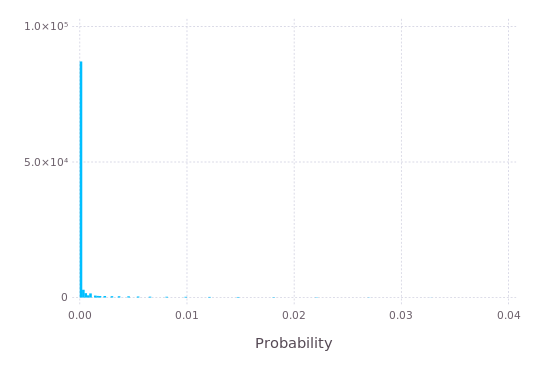

In [597]:
plot(x = [sample(wv) for i = 1:100000], Geom.histogram, Guide.xlabel("Probability"))

Contour plot of probabilities.

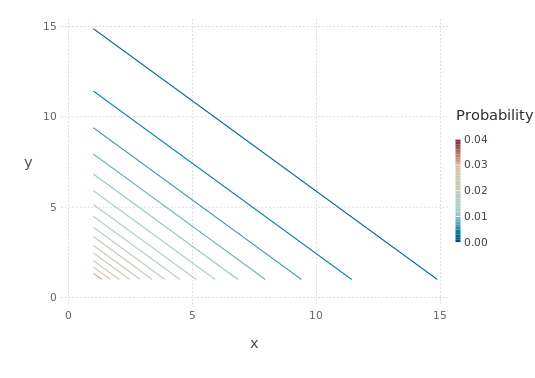

In [598]:
plot(z = (i,j) -> c * sparkProbability(convert(Int, ceil(i)), convert(Int, ceil(j)), n), 
x = [1:100], 
y = [1:100], 
Geom.contour, Guide.colorkey("Probability") )

Now we build out the functions that will actually run our simulation. If we were building a framework we would employ a more OOP style. This amount of complication is right on the cusp of doing so.

This first function is at the core of our CPU use: counting trees burned. Consider this runs length(D) $\times \text{ } n^2 \times$ value(d) $\times$ 100 times and then loops $n^2$ times. To further optimize we would use a recursive algorithm to find each connected component that matches the label.

In [21]:
# TODO: Recursive algorithm
@everywhere function countBurns(labels::Array{Int64,2}, label::Int)
    count = 0
    for l in labels
        if l != 0 && l == label
            count = count + 1
        end
    end
    count
end

In [22]:
function getAverageBurns(labels::Array{Int64, 2}, sparks::Int)
    burns = Array(Int, sparks)
    for i = 1:sparks
        # Generate Spark
        sparkPoint = sample(weights(wv))
        # Burn down the forest
        burns[i] = countBurns(labels, labels[sparkPoint])
    end
    mean(burns)
end

getAverageBurns (generic function with 1 method)

In [23]:
function getaverageburnspar(labels::Array{Int64, 2}, sparks::Int)
    totalburns = @parallel (+) for i = 1:sparks
        # Generate Spark
        sparkPoint = sample(weights(wv))
        # Burn down the forest
        countBurns(labels, labels[sparkPoint])
    end
    totalburns / sparks
end

getaverageburnspar (generic function with 1 method)

In [24]:
function getyieldforlocation(locations::Array{Int}, mat::BitArray{2}, treenumber::Int64)
    locationyield = Array(Float64, length(locations))
    for (k, j) in enumerate(locations)
        # Get avergage yield over 100 random sparks for each tree location
        mat[j] = true
        labels = label_components(mat)
        #burns = getAverageBurns(labels, 100)
        burns = getaverageburnspar(labels, 100)
        #println(burns)
        locationyield[k] = (treenumber - burns) / n^2
        #println("Yield: $(locationyield[k])")
        mat[j] = false
    end
    locationyield
end

getyieldforlocation (generic function with 1 method)

In [29]:
function getyieldfortrees(n::Int64, d::Int64)
    # No tree matrix
    A = falses(n, n)
    # Available spots for trees
    a = Set([1:n^2]) 
    yield = Array(Float64, n^2)
    for i = 1:n^2
        # Select D places to place the tree and compute the yield 
        arraya = collect(a)
        locations = sample(arraya, min(d, length(arraya)), replace = false)
        locationyield = getyieldforlocation(locations, A, i)
        maxyield = maximum(locationyield)
        # Add the winning yield to the yield array
        yield[i] = maxyield
        maxlocation = findfirst(locationyield, maxyield)
        matrixlocation = locations[maxlocation]
        # Add the winning tree to the matrix
        A[matrixlocation] = true
        # Remove the location from the list of available locations
        delete!(a, matrixlocation)
    end    
    yield
end

getyieldfortrees (generic function with 1 method)

In [35]:
yield = [Float64[] for i in D]
for (q, d) in enumerate(D)
    yield[q] = getyieldfortrees(n, d)
end

In [61]:
yield

4-element Array{Array{Float64,1},1}:
 [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014,0.0015,0.0016,0.0017,0.0018,0.0019,0.002,0.0021,0.0022,0.0023,0.0024,0.0025,0.0026,0.0027,0.0028,0.0029,0.003,0.0031,0.0032,0.0033,0.0034,0.0035,0.0036,0.0037,0.0038,0.0039,0.004,0.0041,0.0042,0.0043,0.0044,0.0045,0.0046,0.0047,0.0048,0.0049,0.005,0.0051,0.0052,0.0053,0.0054,0.0055,0.0056,0.0057,0.0058,0.0059,0.006,0.0061,0.0062,0.0063,0.0064,0.0065,0.0066,0.0067,0.0068,0.0069,0.007,0.0071,0.0072,0.0073,0.0074,0.0075,0.0076,0.0077,0.0078,0.0079,0.008,0.0081,0.0082,0.0083,0.0084,0.0085,0.0086,0.0087,0.0088,0.0089,0.009,0.0091,0.0092,0.0093,0.0094,0.0095,0.0096,0.0097,0.0098,0.0099,0.01,0.0101,0.0102,0.0103,0.0104,0.0105,0.0106,0.0107,0.0108,0.0109,0.011,0.0111,0.0112,0.0113,0.0114,0.0115,0.0116,0.0117,0.0118,0.0119,0.012,0.0121,0.0122,0.0123,0.0124,0.0125,0.0126,0.0127,0.0128,0.0129,0.013,0.0131,0.0132,0.0133,0.0134,0.0135,0.0136,0.0137,0.0138,0.0139,0.

In [30]:
function simulationspeed()
    yield = [Float64[] for i in D]
    for (q, d) in enumerate(D)
        yield[q] = getyieldfortrees(n, d)
    end 
end

simulationspeed (generic function with 1 method)

In [33]:
time = 0
for i = 1:10
    time = time + @elapsed simulationspeed()
end
time / 10

14.798641419

This is a nasty hack: go back and change to the parallel version of the burn function.

In [606]:
time = 0
for i = 1:10
    time = time + @elapsed simulationspeed()
end
time / 10

10.134915170000001

Some speed improvment but not much. The issue is that we are moving a lot of data for a little computation. Perhaps we can be happy that Julia itself runs quickly.

# a) Plot of Yield values 

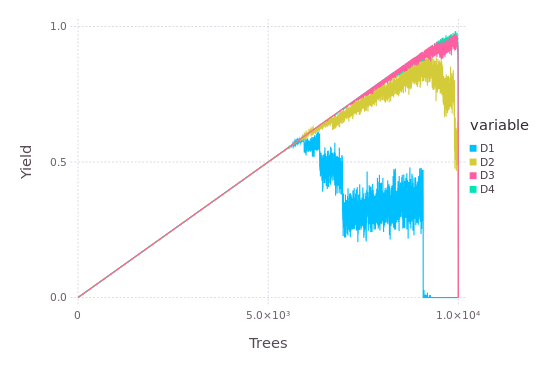

In [75]:
designs = DataFrame(Trees = 1:n^2, D1 = yield[1], D2 = yield[2], D3 = yield[3], D4 = yield[4]);
plot(melt(designs, :Trees), x = "Trees", y = "value", color = "variable", Geom.line, Guide.ylabel("Yield"))

# b) Peak yield values in order of designs 

In [37]:
peakyields = Float64[]
for i in yield
    maxyield = maximum(i)
    push!(peakyields, maxyield)
    println(maxyield) 
end

0.612255
0.913558
0.970985
0.9829709999999999


# c) Plots of distributions of peak yield values 

In [38]:
function getgroupsizes(mat::BitArray{2})
    labels = label_components(mat)
    println(labels)
    groups = collect_groups(labels)
    groupsizes = Array(Int64, length(groups))
    for (i, l) in enumerate(groups)
        groupsizes[i] = length(l) 
    end
    groupsizes
end

getgroupsizes (generic function with 1 method)

In [76]:
function differenceinbounds(α::Float64, ϵ::Float64)
    #-ϵ < α < ϵ
    if α > -ϵ && α < ϵ return(true) end 
    false
end

@test differenceinbounds(.09, .1) == true
@test differenceinbounds(-.09, .1) == true

In [77]:
function getyieldfortrees(n::Int64, d::Int64, ϵ::Float64, peakyields::Array{Float64})
    # No tree matrix
    A = falses(n, n)
    # Available spots for trees
    a = Set([1:n^2]) 
    yield = Array(Float64, n^2)
    for i = 1:n^2
        # Select D places to place the tree and compute the yield 
        arraya = collect(a)
        locations = sample(arraya, min(d, length(arraya)), replace = false)
        locationyield = getyieldforlocation(locations, A, i)
        maxyield = maximum(locationyield)
        # Add the winning yield to the yield array
        yield[i] = maxyield
        maxlocation = findfirst(locationyield, maxyield)
        matrixlocation = locations[maxlocation]
        # Add the winning tree to the matrix
        A[matrixlocation] = true
        # Remove the location from the list of available locations
        delete!(a, matrixlocation)
        # If we are near our max yield get the distribution and break the loop
        α = maxyield - peakyields[q]
        if differenceinbounds(α, ϵ)
            return(getgroupsizes(A))
        end
    end   
    Int64[]
end

getyieldfortrees (generic function with 2 methods)

In [65]:
D = [1,2]

2-element Array{Int64,1}:
 1
 2

In [78]:
distributions = [Int64[] for i in D]
for (q, d) in enumerate(D)
    distributions[q] = getyieldfortrees(n, d, 0.1, peakyields)
end

[0 1 1 0 0 1 0 1 0 0 82 82 82 82 0 0 0 123 123 0 139 0 0 159 159 159 159 0 0 0 159 0 0 216 0 226 226 0 0 255 0 0 273 0 0 0 274 0 309 0 326 326 0 326 326 0 0 365 365 0 0 316 316 316 316 0 0 316 316 0 316 316 316 316 0 474 0 0 490 0 0 498 498 0 519 519 519 0 0 0 577 0 0 585 585 585 0 0 618 0
 0 1 1 0 1 1 1 1 0 0 0 82 82 0 0 107 107 0 123 123 0 0 0 0 0 0 159 159 159 0 159 0 0 0 0 0 0 0 0 0 0 0 0 274 274 274 274 0 0 0 326 326 326 326 326 0 0 0 0 316 0 0 316 316 316 0 0 316 0 0 316 316 0 0 0 0 0 0 0 497 497 0 498 498 0 0 519 0 519 519 0 0 0 0 585 585 585 585 0 0
 0 0 1 0 1 1 1 1 1 1 0 0 0 0 107 107 107 107 0 0 140 0 152 0 0 0 159 0 159 159 159 159 0 0 0 0 234 0 247 247 0 0 274 274 274 274 274 0 310 310 0 326 326 326 0 0 0 0 316 316 316 316 0 316 316 316 316 316 316 316 316 316 0 0 464 464 464 0 0 0 0 498 498 0 519 519 519 519 519 519 0 585 585 585 585 585 0 0 619 619
 1 1 1 1 1 1 0 1 1 0 83 83 83 0 107 107 0 107 107 0 0 0 0 160 0 0 0 186 0 159 159 159 0 0 0 227 0 0 0 247 247 0 0 0 0 274 274

In [79]:
distributions

2-element Array{Array{Int64,1},1}:
 [28,1,2,1,2,1,5,1,5,7,3,1,2,39,6,1,15,1,78,2,1,5,1,256,2,11,42,1,1,2,4,1,3,1,2,4,3,2,1,15,3,6,24,1,1,1,4,2,1,1,5,2,4,1,1,1,1,1,1,43,1,36,2,3,2,4,34,1,1,227,8,1,1,1,1,4,1,1,12,4,12,6,10,4,1,5,1,1,14,1,8,1,1,2,1,1,3,3,3,16,1,1,4,1,2,1,13,1,1,1,4,36,14,3,2,5,1,1,1,14,11,1,4,8,13,1,4,1,1,8,4,1,1,1,44,1,23,1,1,1,2,3,1,7,1,2,1,33,5,1,1,1,1,2,1,1,53,1,17,6,6,1,2,9,2,4,1,2,41,1,29,5,1,68,4,19,2,1,1,2,61,2,2,3,2,2,47,1,1,2,1,4,1,1,21,5,1,3,4,2,1,37,71,1,1,12,29,7,1,3,1,3,1,4,1,1,1,3,1,1,4,2,1,3,9,2,1,1,1,1,2,1,6,1,1,4,2,1,1,20,16,1,14,1,76,1,4,4,1,2,2,44,9,1,1,5,2,35,1,1,1,1,4,30,4,2,1,1,1,1,1,18,1,12,3,2,3,3,2,1,1,1,3,1,25,1,1,25,1,1,7,3,4,2,1,2,19,12,1,1,10,1,3,1,1,1,65,8,1,5,4,1,4,4,4,292,1,1,11,1,4,13,2,1,1,14,1,39,1,1,4,9,44,5,7,1,1,1,2,1,1,4,26,17,12,1,1,1,1,1,4,13,15,2,18,1,1,1,1,1,1,2,61,8,2,2,3,1,1,3,2,1,1,1,18,18,1,1,48,3,10,4,1,1,1,11,1,1,9,2,41,2,1,2,1,9,1,1,1,10,1,15,2,3,1,2,1,46,12,11,1,1,16,1,17,9,8,11,1,1,2,7,1,6,1,2,3,7,2,3,3,155,1,1,5,1,2,1,

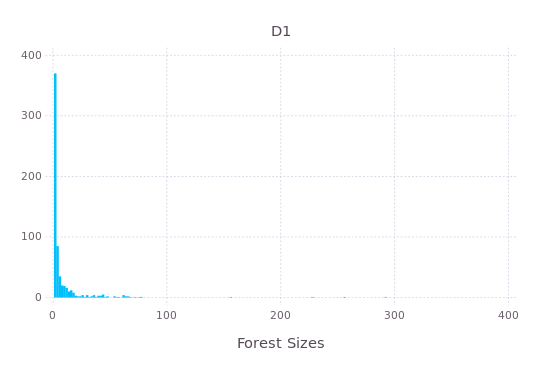

In [80]:
plot(x = distributions[1], Geom.histogram, Guide.title("D1"), Guide.xlabel("Forest Sizes"))

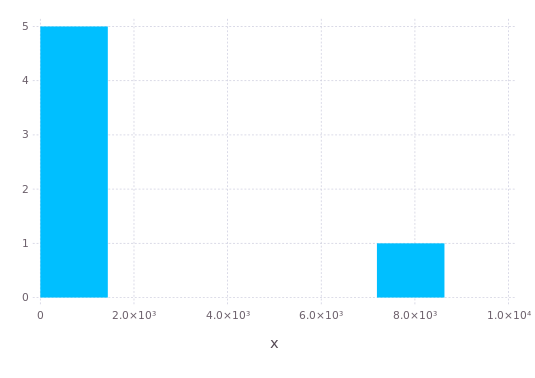

In [81]:
plot(x = distributions[2], Geom.histogram)

In [454]:
D = [1,2]
yield = [Float64[] for i in D]
ϵ = 0.01
q = 1
distributions = [Int[] for i in D]
for d in D
    # No tree matrix
    A = falses(n, n)
    # Spots for trees
    a = Set([1:n^2]) 
    dyield = Array(Float64, n^2)
    for i = 1:n^2
        #println("Current Forest State:")
        #println(A)
        # Select D places to place the tree and compute the yield 
        arraya = collect(a)
        locations = sample(arraya, min(d, length(arraya)), replace = false)
        locationyield = Array(Float64, length(locations))
        for (k, j) in enumerate(locations)
            # Get avergage yield over 100 random sparks for each tree location
            A[j] = true
            labels = label_components(A)
            burns = getAverageBurns(labels, 100)
            #println(burns)
            locationyield[k] = (i - burns) / n^2
            #println("Yield: $(locationyield[k])")
            A[j] = false
        end
        maxyield = maximum(locationyield)
        #println("Max Yield: $maxyield")
        # Add the winning yield to the yield array
        dyield[i] = maxyield
        maxlocation = findfirst(locationyield, maxyield)
        matrixlocation = locations[maxlocation]
        # Add the winning tree to the matrix
        A[matrixlocation] = true
        # Remove the location from the list
        locina = findfirst(arraya, matrixlocation)
        #println("Chose location $(matrixlocation) with yield $(dyield[i]) from locations: $arraya")
        delete!(a, matrixlocation)
        #println("")
        α = maxyield - peakyields[q]
        println("i: $i")
        if differenceinbounds(α, ϵ)
            println("Breaking at yield value: $maxyield")
            distributions[q] = getgroupsizes(A)
            break;
        end
    end
    yield[q] = dyield
    q = q + 1
end

i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
Breaking at yield value: 0.4428
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
Breaking at yield value: 0.7114
